# Full analysis of the trained model

In this notebook, we analyse the semi-supervised model with contrastive learning:

1. We **load** the trained model  
2. We **evaluate** it on the validation set  
3. We **visualize** predictions vs ground truth  
4. We run a **quantitative analysis** (Dice per class, metrics, etc.)  
5. We run a **qualitative analysis** (examples, errors, t-SNE, etc.)  

Device: mps
Device = mps
Labeled=2  |  Unlabeled=52  |  Val=2
Trainer ready
Validation batches: 1
Model loaded from experiments_ACDC/joint_best.pth
Best validation Dice (training): 0.804174562295278
num_classes: 4
class_names: ['Background', 'rv', 'myo', 'lv']

Global validation Dice: 0.804174562295278

Dice per class:
Background     : 0.9943
rv             : 0.7479
myo            : 0.7446
lv             : 0.9200


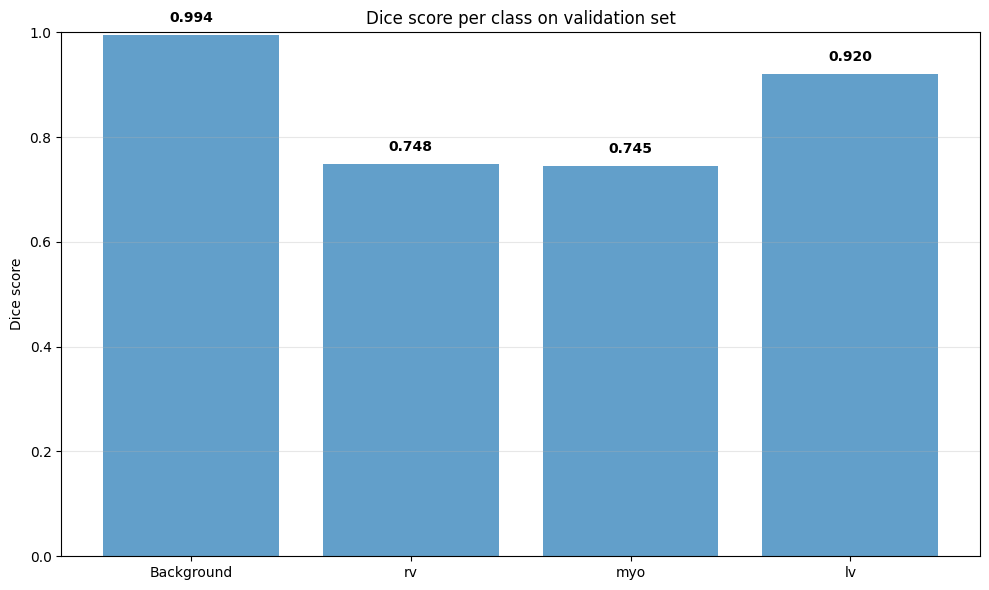


Mean foreground Dice: 0.8041746


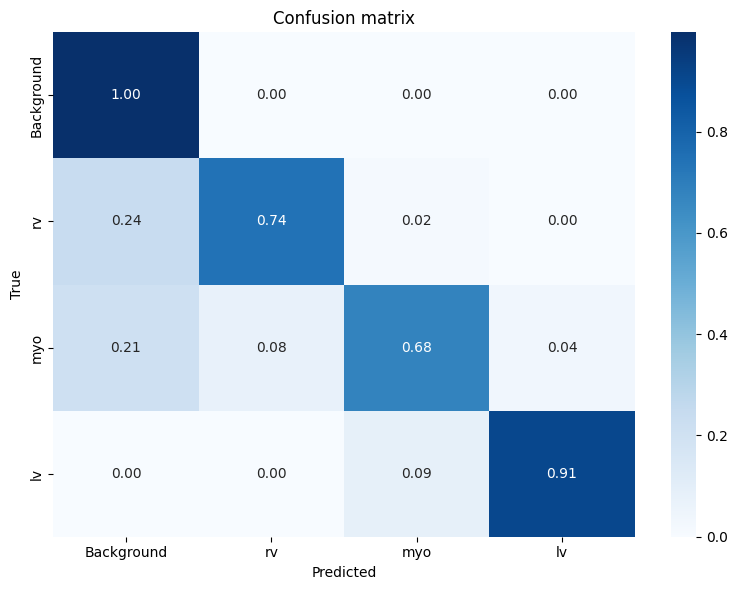


Dice score statistics
Mean   : 0.7109
Std    : 0.1976
Min    : 0.0000
Max    : 0.8528
Median : 0.8017


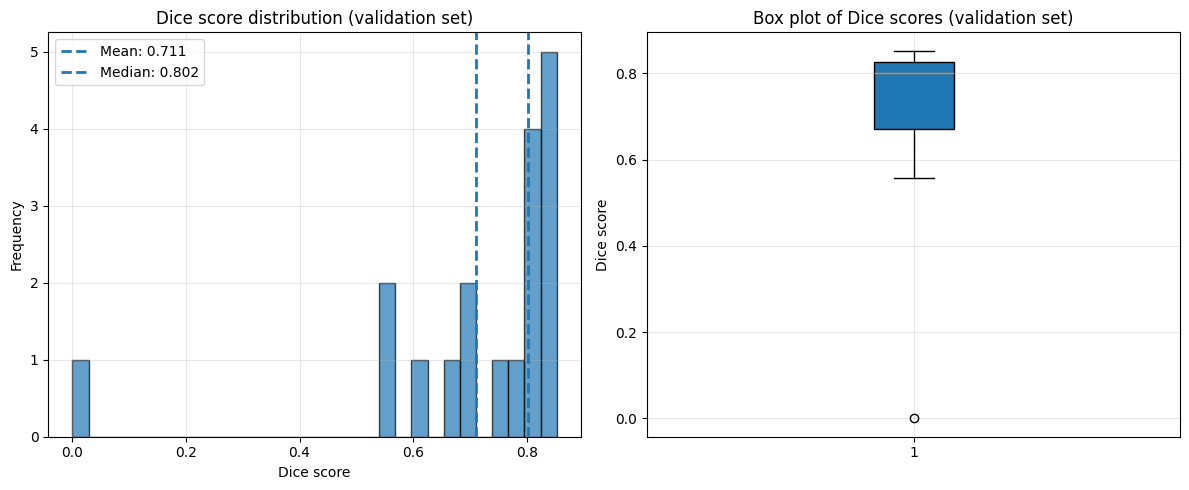

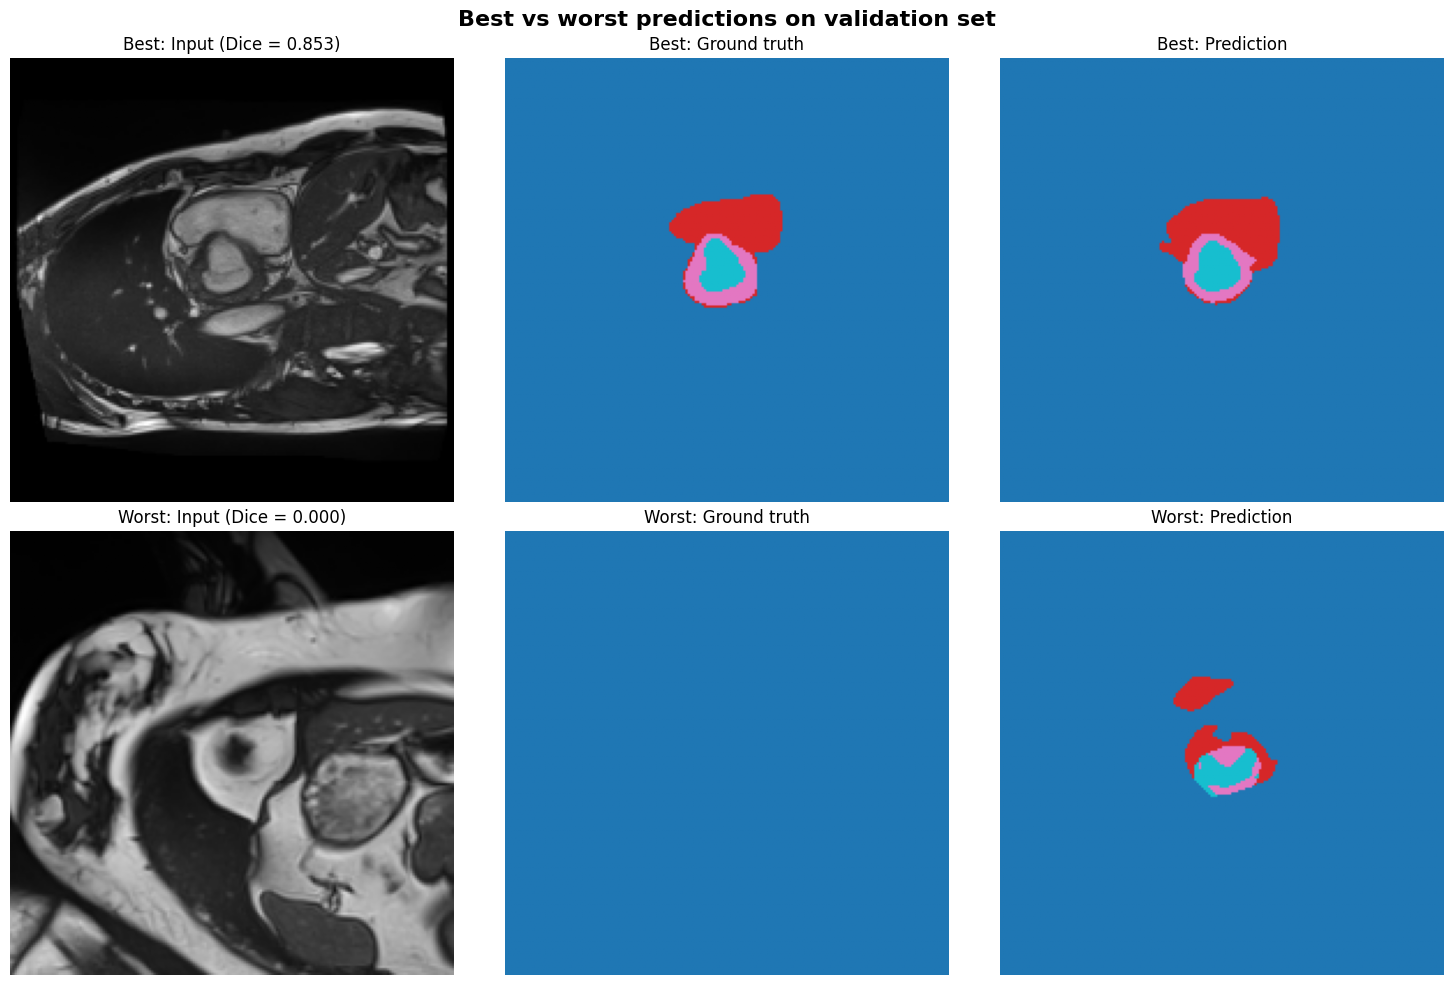

Running t-SNE on 20000 pixels, feature dim = 4


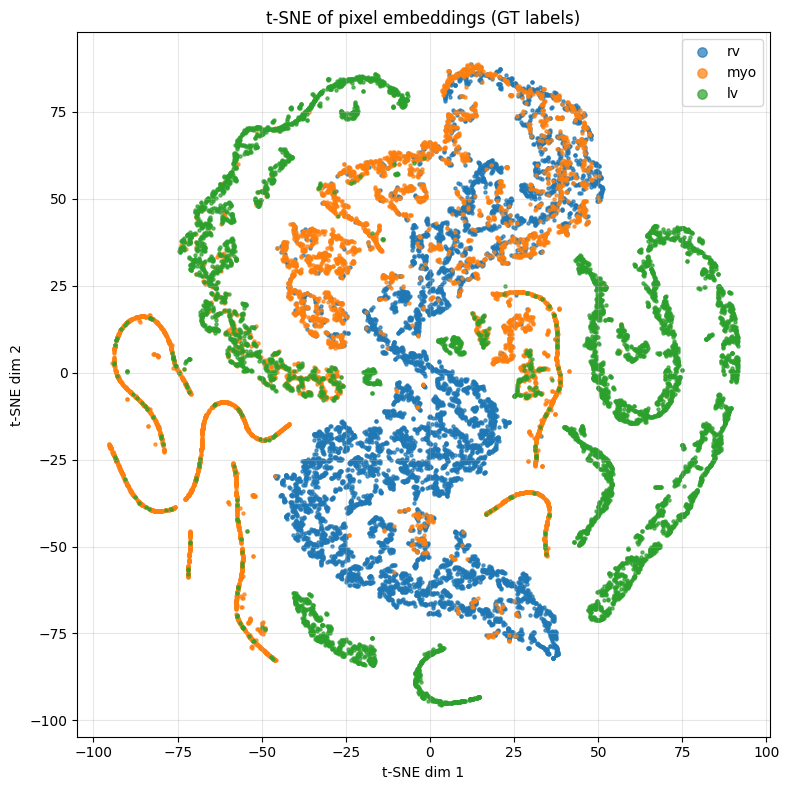

Dice per volume (patient)
Patient 031: Dice = 0.8084
Patient 072: Dice = 0.7920
Average Dice over patients: 0.8002


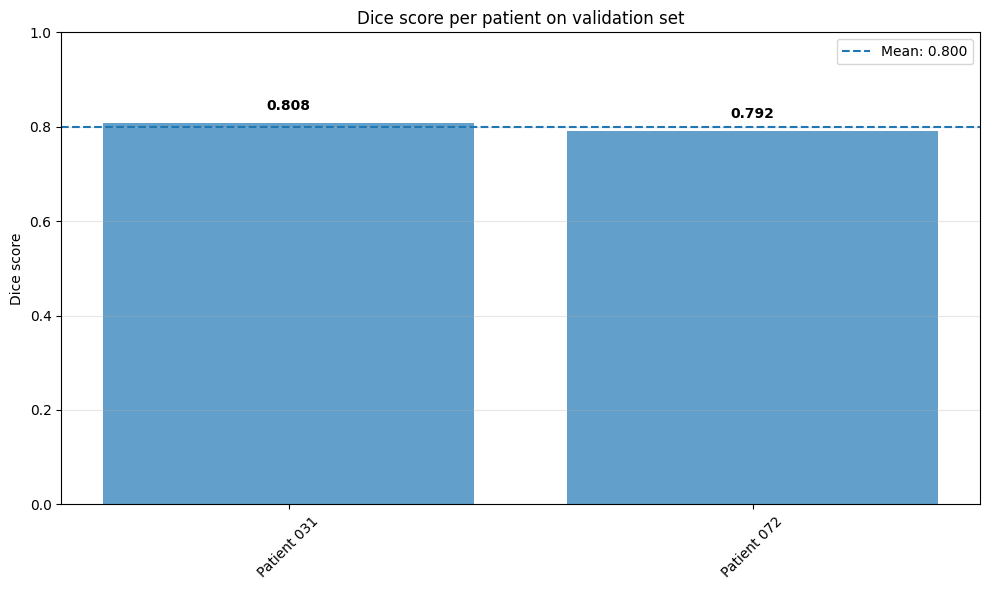

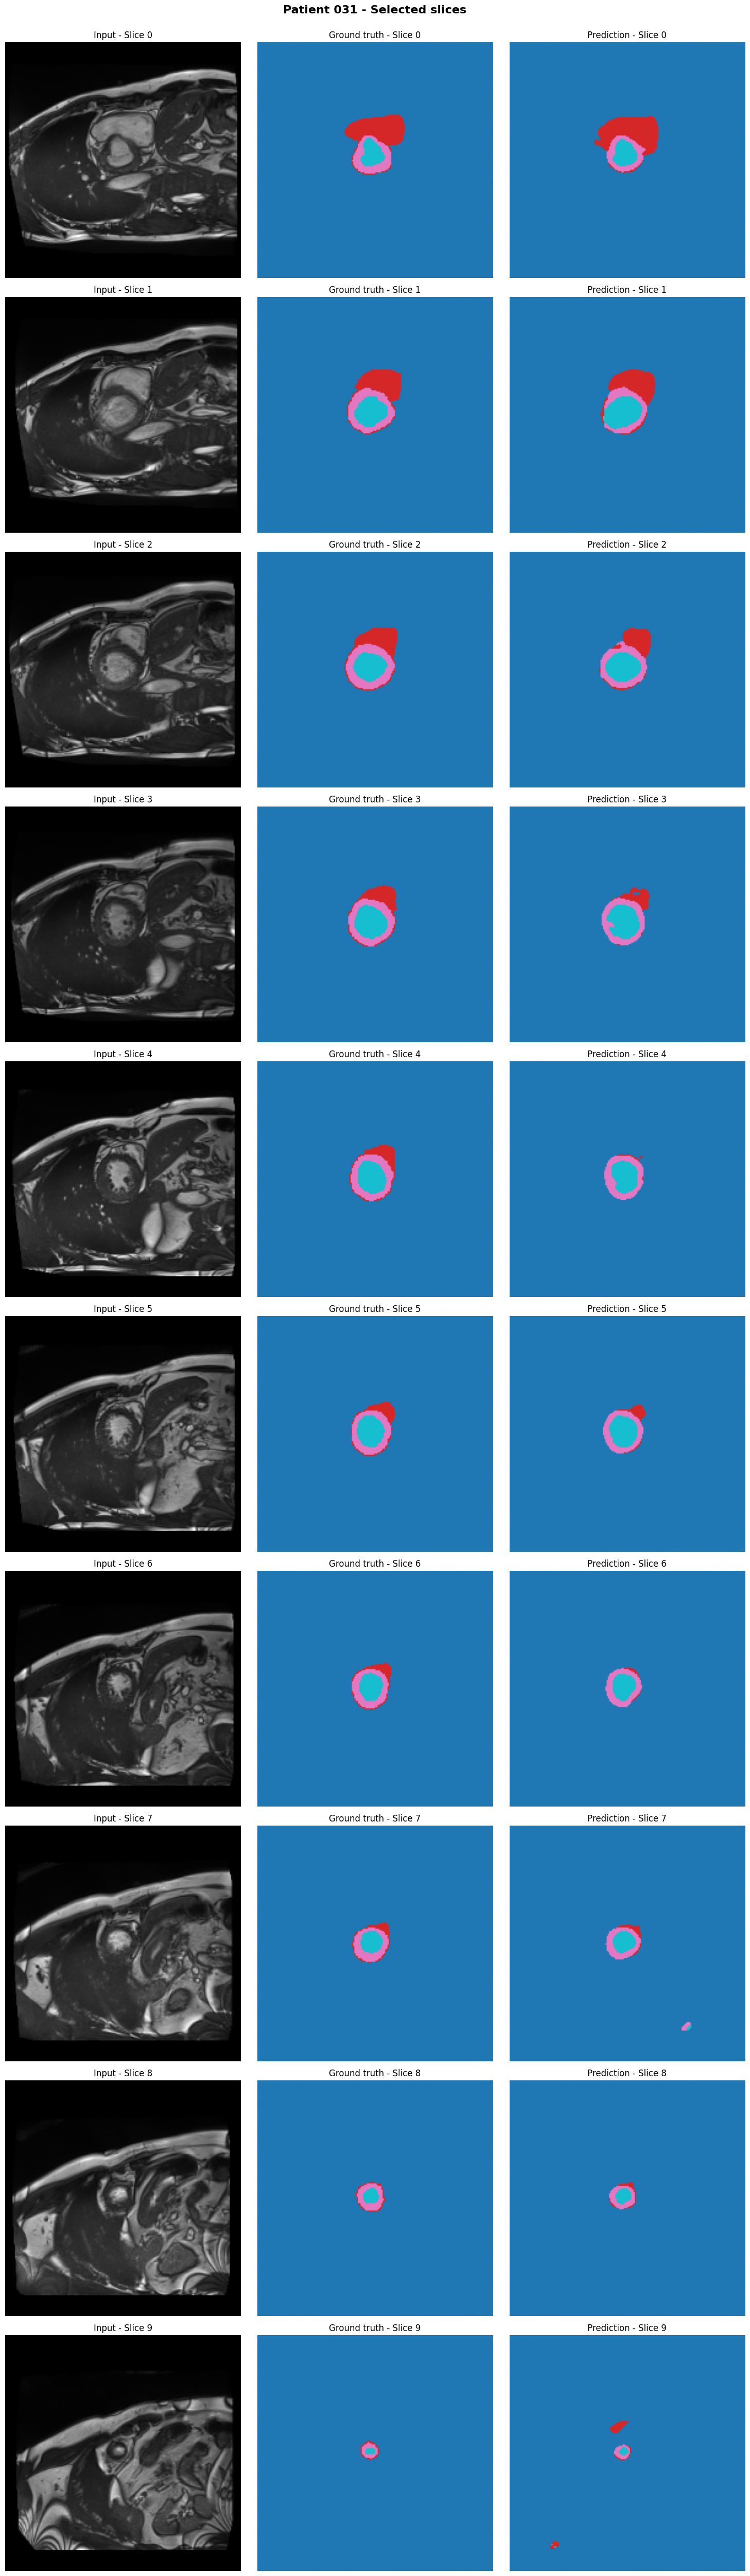

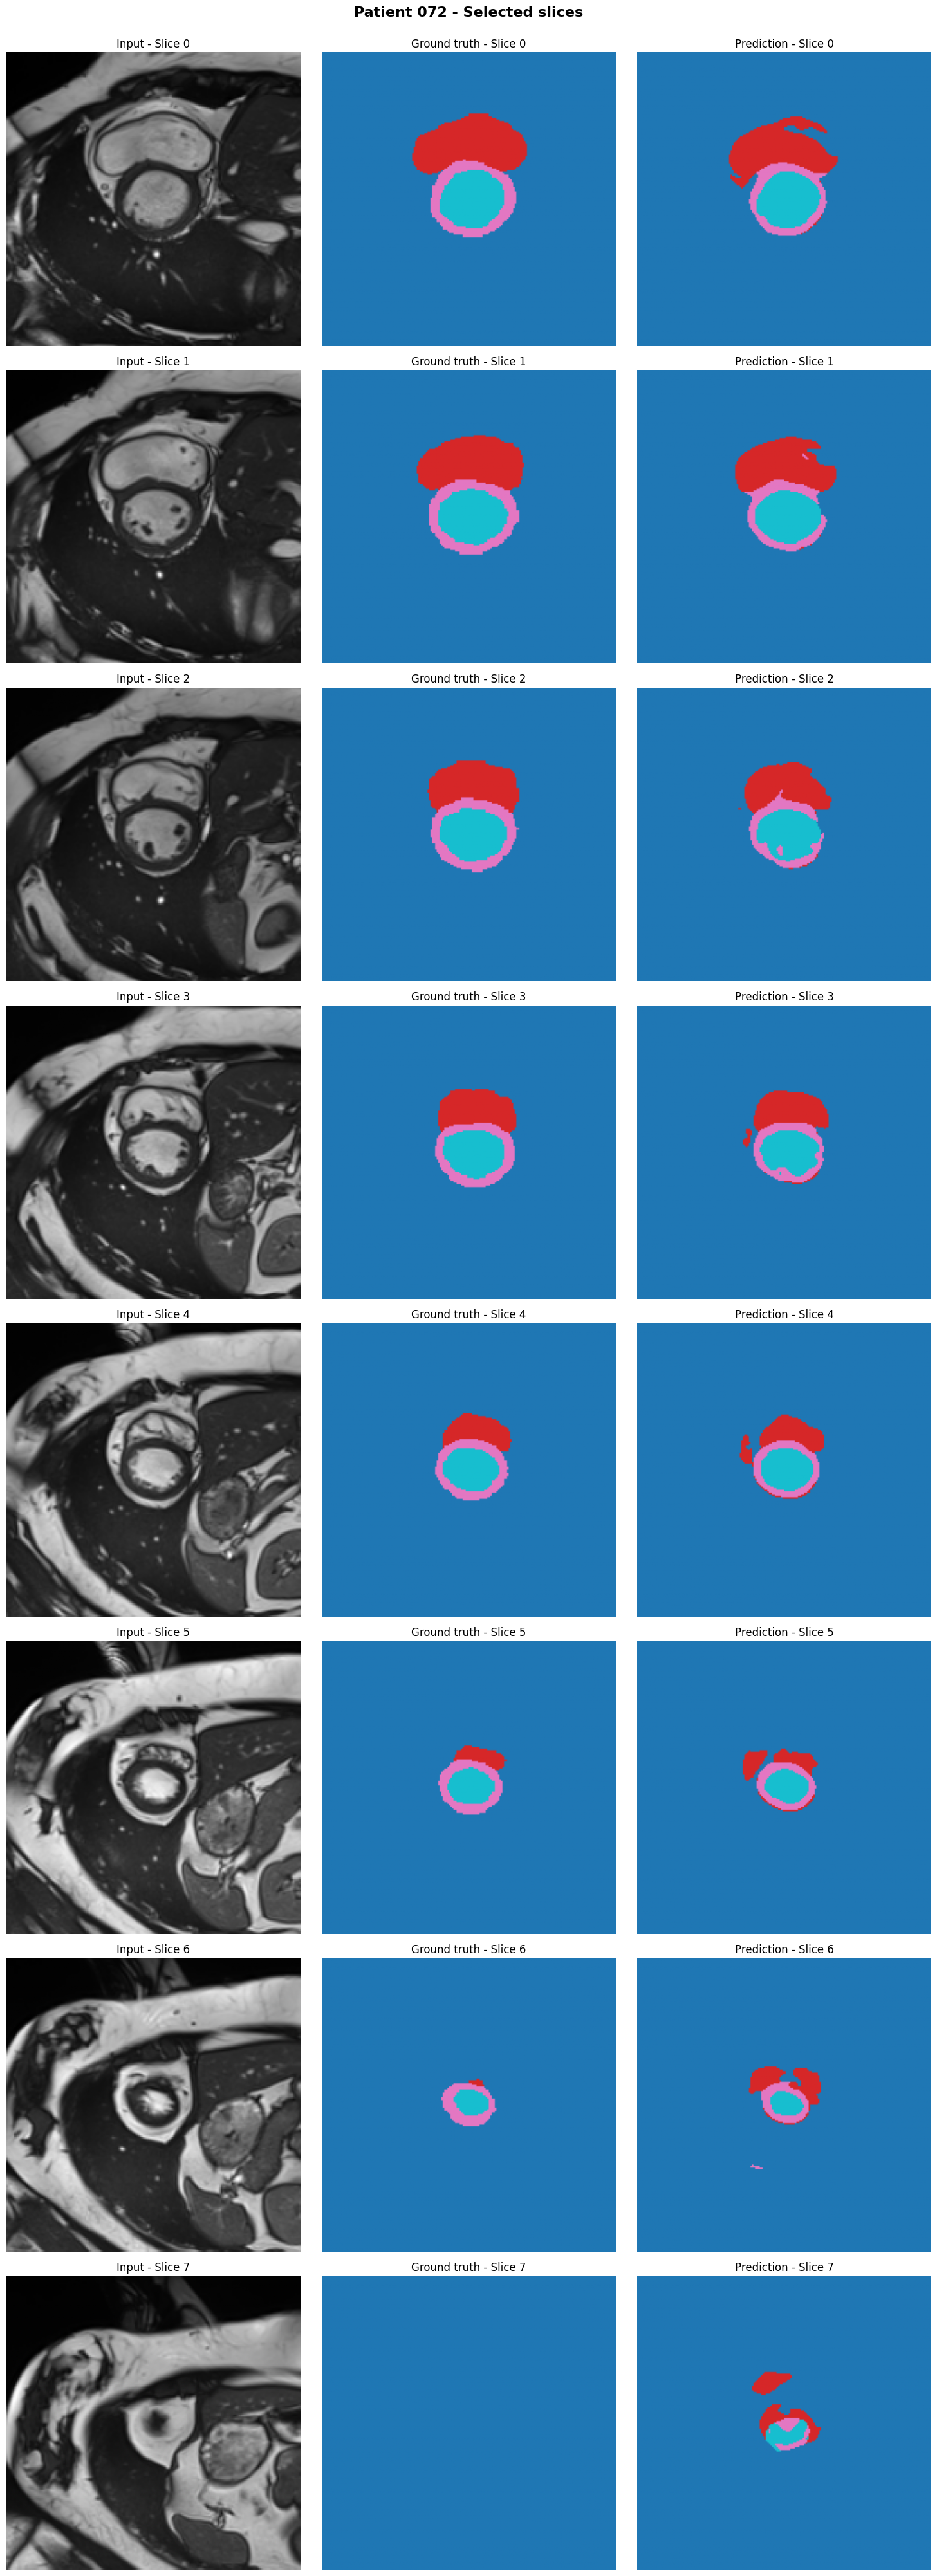

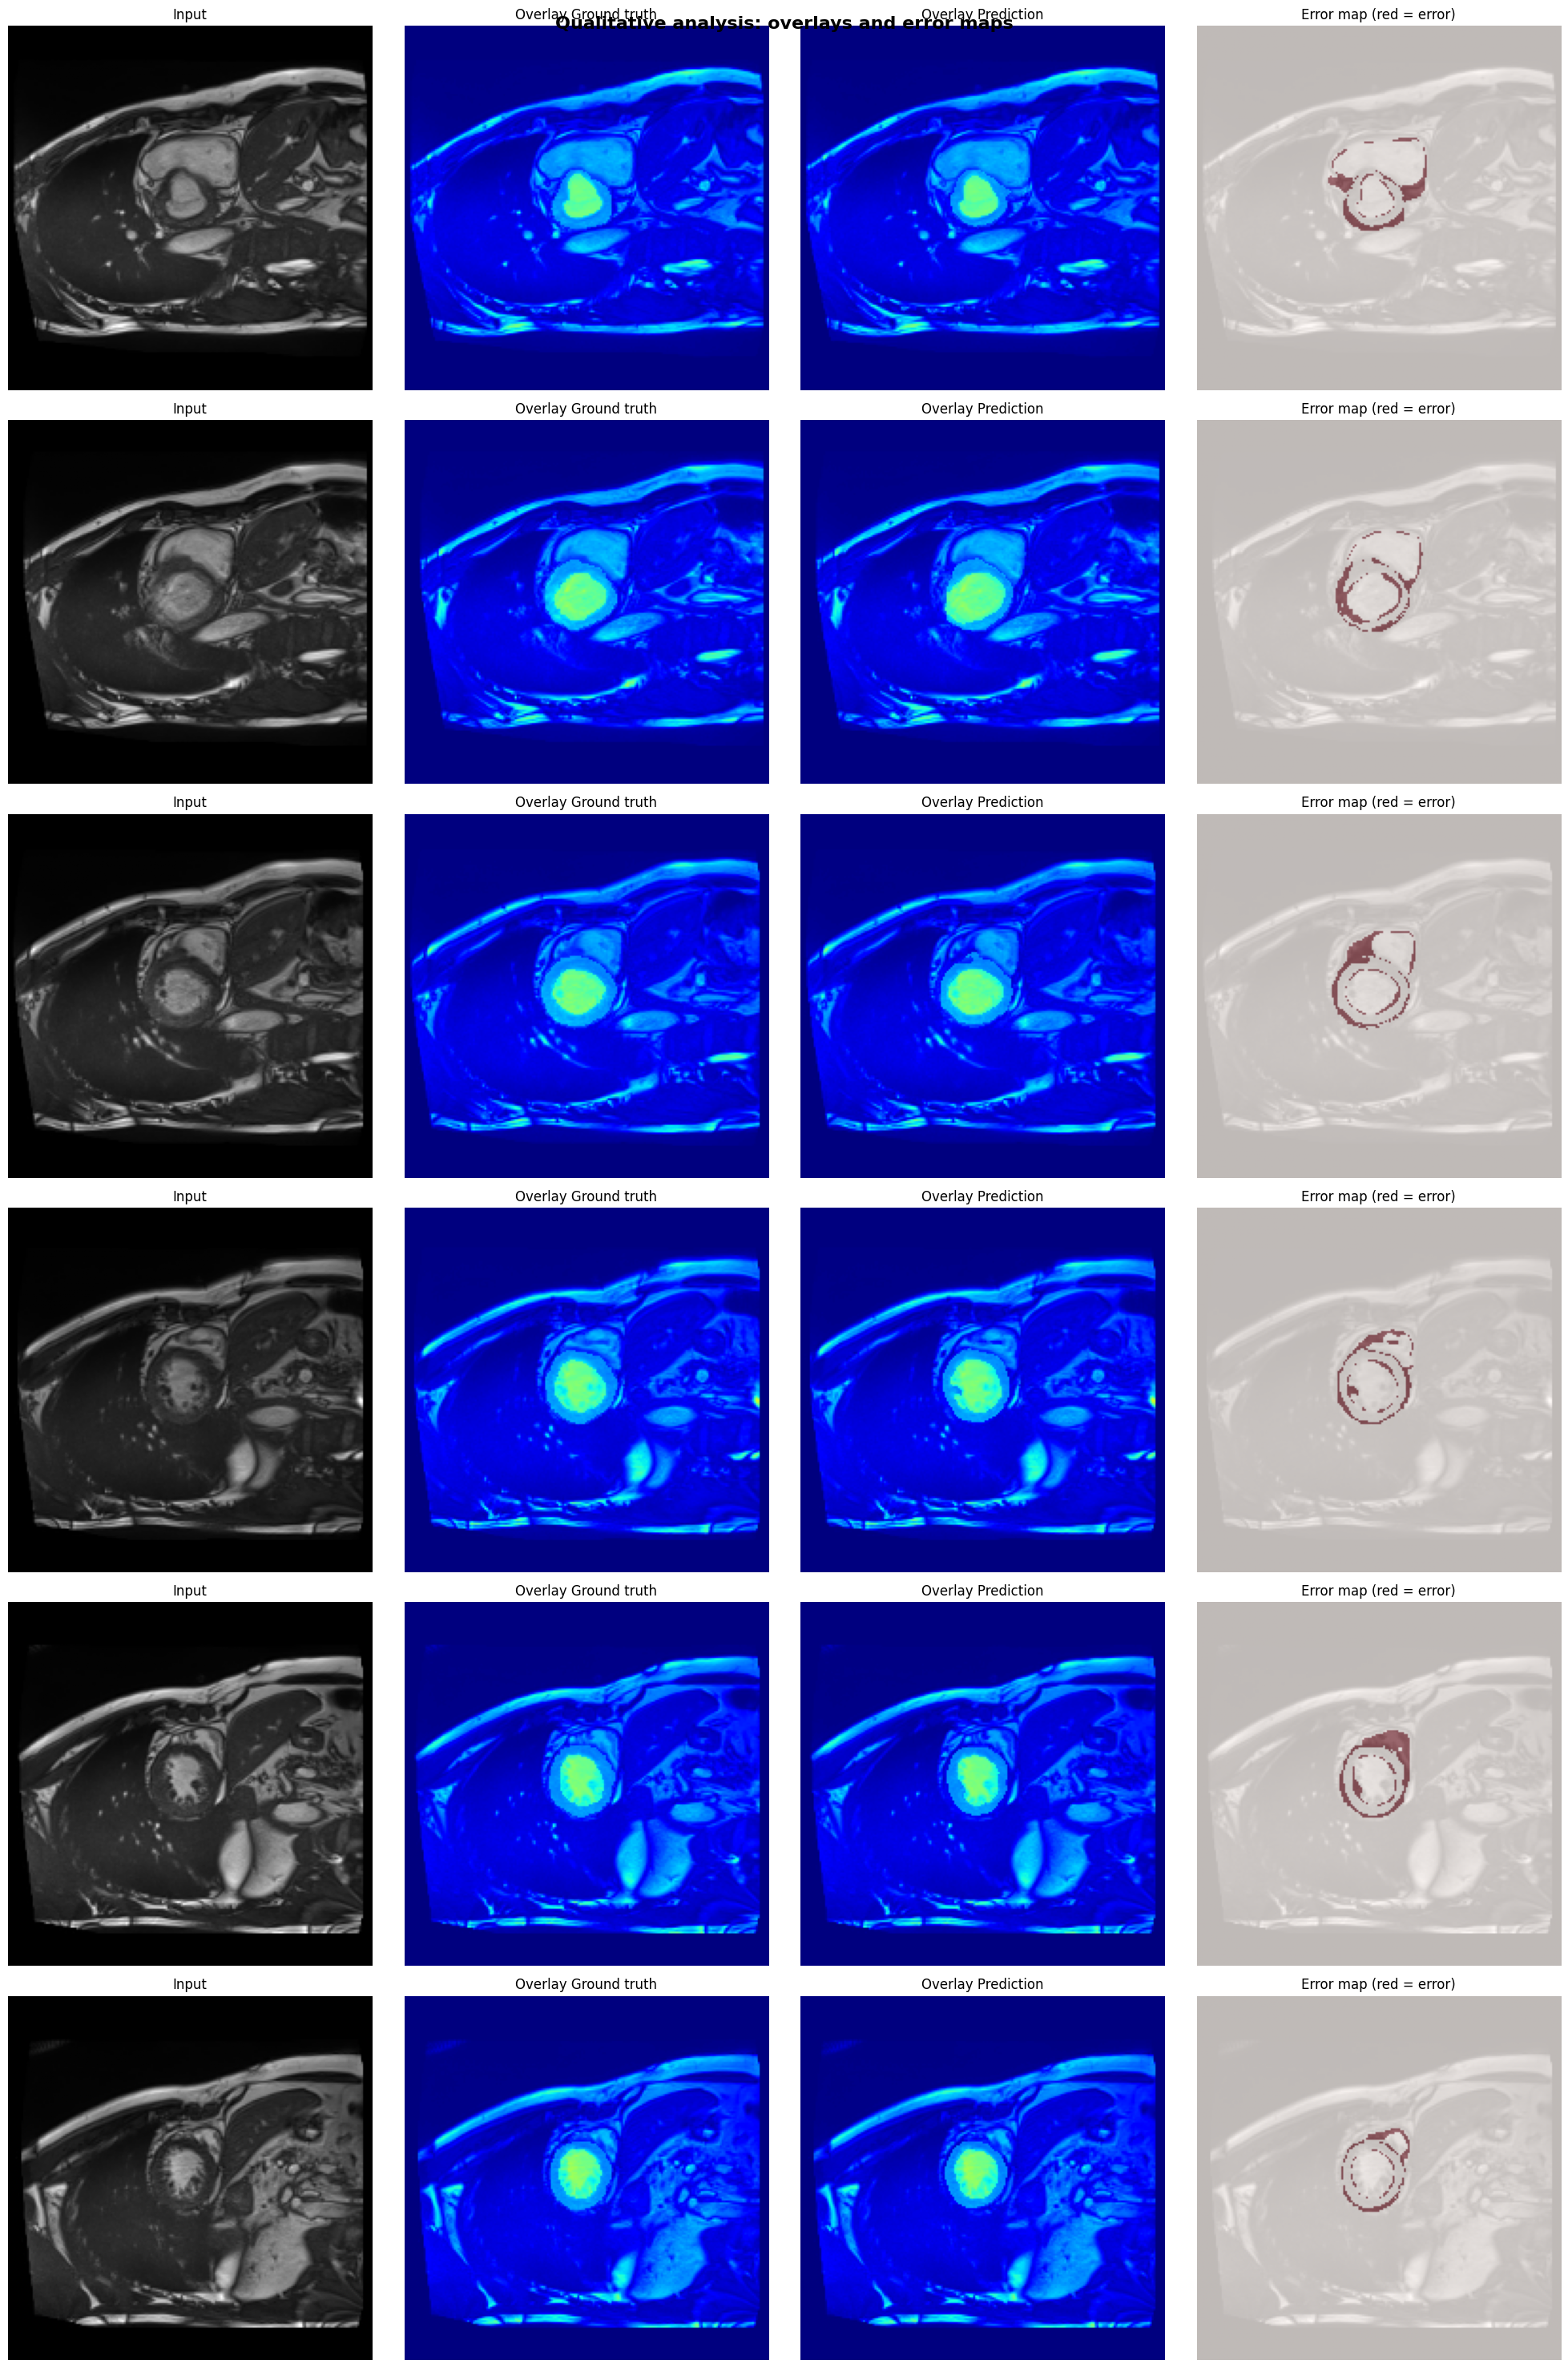

In [ ]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml
from pathlib import Path

# Project root
root_dir = Path.cwd().resolve()
sys.path.insert(0, str(root_dir))

from Our_pytorch_version.trainers import ContrastiveTrainer
from Our_pytorch_version.utils import compute_dice_score
from segmentation_eval_utils import (
    get_num_classes,
    get_class_names,
    collect_val_predictions,
    compute_dice_per_class_batch,
    plot_dice_per_class,
    compute_slice_dice_all,
    plot_dice_hist_and_box,
    show_best_worst_examples,
    visualize_batch_predictions,
    visualize_overlays_and_errors,
    build_val_volume_dataset,
    compute_and_plot_volume_dice,
    visualize_volume_slices_for_patient,
    plot_confusion_matrix_from_preds,
    compute_tsne_pixel_embeddings,   
    plot_tsne_embeddings,            
)

# 1. Load config and trainer

config_path = "Our_pytorch_version/configs/config_acdc.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

# Device
device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
print("Device:", device)

# Seeds
torch.manual_seed(42)
np.random.seed(42)

# Trainer
trainer = ContrastiveTrainer(config_path)
trainer.prepare_data()

print("Trainer ready")
print("Validation batches:", len(trainer.val_loader))

# Load model checkpoint
model_path = "our_experiments/experiments_ACDC/joint_best.pth"
checkpoint = torch.load(model_path, map_location=device)
trainer.model.load_state_dict(checkpoint["model_state_dict"])
trainer.model.to(device)
trainer.model.eval()

print("Model loaded from", model_path)
if "best_val_dice" in checkpoint:
    print("Best validation Dice (training):", checkpoint["best_val_dice"])

# Get num_classes and names from config (generic)
num_classes = get_num_classes(config)
class_names = get_class_names(config)
print("num_classes:", num_classes)
print("class_names:", class_names)

# 2. Global validation Dice (trainer)

val_dice = trainer.validate()
print("\nGlobal validation Dice:", val_dice)

# 3. Dice per class on full validation set

all_preds, all_targets = collect_val_predictions(trainer, device)
dice_per_class = compute_dice_per_class_batch(all_preds, all_targets, num_classes)

print("\nDice per class:")
for name, dice in zip(class_names, dice_per_class):
    print(f"{name:15s}: {dice:.4f}")

plot_dice_per_class(dice_per_class, class_names, title_suffix="validation set")

# Mean Dice over foreground (if background is class 0)
if num_classes > 1:
    mean_fg_dice = np.mean(dice_per_class[1:])
    print("\nMean foreground Dice:", mean_fg_dice)


# 4. Confusion matrix

plot_confusion_matrix_from_preds(
    all_preds, all_targets, num_classes, class_names, normalize=True
)

# 5. Slice-wise Dice distribution + best/worst examples

dice_scores_arr, images_list, preds_list, masks_list = compute_slice_dice_all(
    trainer, device, num_classes, compute_dice_score_fn=compute_dice_score
)

plot_dice_hist_and_box(dice_scores_arr, title_prefix="validation set")
show_best_worst_examples(
    dice_scores_arr, images_list, preds_list, masks_list, num_classes
)
val_dataset = build_val_volume_dataset(config, root_dir)

# TSNE of pixel embeddings
def feature_fn(model, x):
    """Extract pixel-wise logits from model.
    """

    logits = model(x)              # [N, num_classes, H, W]
    return logits                  # shape is fine for t-SNE


emb_2d, labels_tsne = compute_tsne_pixel_embeddings(
    trainer,
    device,
    num_classes,
    feature_fn=feature_fn,
    max_pixels=20000,
    use_gt_labels=True,   # color by GT class
)

plot_tsne_embeddings(
    emb_2d,
    labels_tsne,
    class_names=class_names,
    title="t-SNE of pixel embeddings (GT labels)",
)

# 6. Volume-level evaluation (if dataset is volumetric)
patient_dices = compute_and_plot_volume_dice(
    trainer.model,
    val_dataset,
    config,
    device,
    compute_dice_score_fn=compute_dice_score,
)


for vol_idx in range(len(val_dataset)):
    img_vol, mask_vol = val_dataset[vol_idx]
    patient_name = config["dataset"]["val_ids"][vol_idx]
    visualize_volume_slices_for_patient(
        trainer.model,
        img_vol,
        mask_vol,
        patient_name,
        device,
        num_classes,
        max_slices=12,
    )

# 7. Overlays and error maps
visualize_overlays_and_errors(trainer, device, num_classes, n_samples=6)
